In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('Data_train.csv')

In [3]:
data

,CLIENTE,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X79,X80,X81,X82,X83,X84,X85,X86,X87,y
0,C_26572,2,3,3,15.652542,8.294133,7.358409,10.203390,3,4,...,0,No,No,No,951,79,872,89.0,10.0,0
1,C_47823,1,1,1,6.779661,1.288000,5.491661,6.779661,1,2,...,1,No,No,No,628,54,574,628.0,574.0,1
2,C_28925,7,49,51,319.355932,120.441150,198.914782,233.584746,4,7,...,1,No,No,No,969,9,960,35.0,26.0,0
3,C_74142,12,68,86,3153.338983,2171.714952,981.624031,1633.932203,14,90,...,1,No,Si,No,968,5,963,8.0,3.0,0
4,C_32527,12,39,41,370.423729,163.928936,206.494793,270.118644,3,41,...,0,No,Si,No,943,4,939,6.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57626,C_56999,3,3,3,16.762712,8.051283,8.711429,11.762712,3,5,...,1,No,No,No,957,29,928,206.0,177.0,0
57627,C_26316,3,3,3,49.957627,45.902857,4.054770,16.864407,1,5,...,1,No,No,No,970,7,963,57.0,50.0,0
57628,C_21636,2,4,4,12.898305,3.710100,9.188205,12.898305,2,6,...,0,No,No,No,861,3,858,4.0,1.0,0
57629,C_63918,5,7,7,136.474576,80.572840,55.901736,79.491525,6,12,...,1,No,No,No,258,8,250,18.0,10.0,0


In [16]:
data.shape

(57631, 90)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57631 entries, 0 to 57630
Data columns (total 90 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CLIENTE  57631 non-null  object 
 1   X0       57631 non-null  int64  
 2   X1       57631 non-null  int64  
 3   X2       57631 non-null  int64  
 4   X3       57631 non-null  float64
 5   X4       57631 non-null  float64
 6   X5       57631 non-null  float64
 7   X6       55257 non-null  float64
 8   X7       57631 non-null  int64  
 9   X8       57631 non-null  int64  
 10  X9       57631 non-null  int64  
 11  X10      57628 non-null  float64
 12  X11      57631 non-null  int64  
 13  X12      57631 non-null  int64  
 14  X13      57631 non-null  int64  
 15  X14      57631 non-null  int64  
 16  X15      57631 non-null  int64  
 17  X16      57631 non-null  int64  
 18  X17      57631 non-null  int64  
 19  X18      41205 non-null  float64
 20  X19      42642 non-null  float64
 21  X20      576

In [5]:
data.isna().sum().sort_values(ascending=False).to_frame()

,0
X18,16426
X19,14989
X21,10585
X78,4522
X6,2374
...,...
X31,0
X30,0
X29,0
X28,0


In [7]:
data.X19.value_counts()

14.322034     113
2.542373      106
12.627119      76
5.084746       74
0.000000       72
             ... 
355.550847      1
160.703390      1
344.338983      1
441.059322      1
49.652542       1
Name: X19, Length: 25971, dtype: int64

In [19]:
sns.boxplot(data.X19=)

KeyboardInterrupt: 

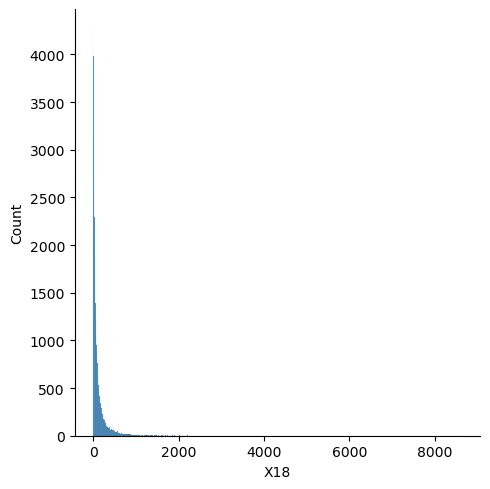

In [10]:
sns.displot(data.X18)

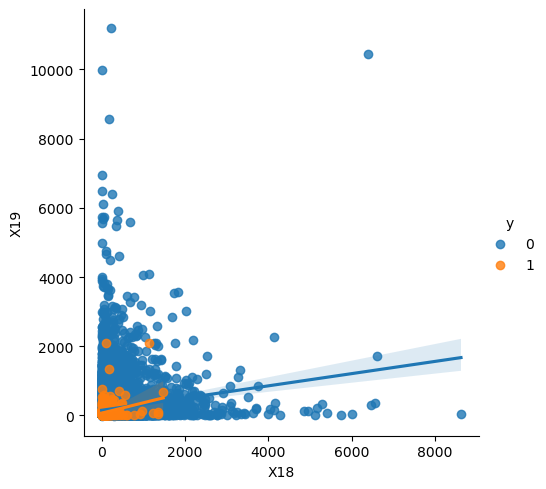

In [14]:
sns.lmplot(data=data , x="X18", y= 'X19', hue='y')

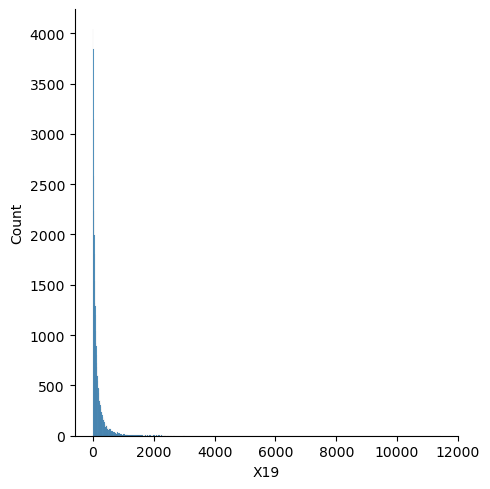

In [9]:
sns.displot(data.X19)

In [6]:
data.X18.value_counts()

2.542373      119
7.203390      117
5.000000       83
5.508475       80
7.627119       76
             ... 
517.627119      1
71.889831       1
635.872881      1
86.381356       1
107.796610      1
Name: X18, Length: 22478, dtype: int64

In [13]:
data.isna().sum().sort_values(ascending=False).to_frame()[:10].index #/ data.shape[0] * 100

Index(['X18', 'X19', 'X21', 'X78', 'X6', 'X87', 'X86', 'X10', 'X73',
       'CLIENTE'],
      dtype='object')

In [14]:
data.drop(columns=['X18', 'X19', 'X21', 'X78', 'X6', 'X87', 'X86', 'X10', 'X73'], axis=1, inplace=True)

In [15]:
from sklearn.linear_model import LogisticRegression

In [20]:
from sklearn.model_selection import train_test_split
X = data.drop(columns='y', axis=1)
y = data.y

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)
print(X_train.shape[0])
print(y_train.shape[0])


40341
40341


In [21]:
lm = LogisticRegression(random_state=0)
lm.fit(X_train, y_train)

ValueError: could not convert string to float: 'C_29324'